In [2]:
import os
import inspect
import sys
import pandas as pd
import charts
import numpy as np
import pylab as pl
from scipy import spatial
from scipy.spatial import distance


from opengrid.library import houseprint

Server running in the folder /usr/local/opengrid/notebooks/Analysis/Thesis_Max&Jean at 127.0.0.1:54730


In [3]:
hp = houseprint.Houseprint()

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
30 Sites created
30 Devices created
87 sensors created
Houseprint parsing complete


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

In [5]:
gas = hp.find_sensor('212ce724e124fbde0fb649396375d099')

In [6]:
head = pd.Timestamp('20151110')
tail = pd.Timestamp('20151118')
originalGraph = gas.get_data(head=head, tail=tail, diff=True, resample='min', unit='kW')
charts.plot(originalGraph, stock=True, show='inline')

Using tmpo database from /data/.tmpo/tmpo.sqlite3


In [7]:
def euclideanDistance(s1,s2):
    #Verwacht een numpy array
    dist = np.linalg.norm(s1-s2)
    return dist

In [8]:
def cosineSimilarity(s1,s2):
    similarity = 1 - spatial.distance.cosine(s1, s2)
    return similarity

In [9]:
def mahalanobisDistance(s1,s2):
    similarity = 1 - distance.mahalanobis(s1,s2)
    return similarity

In [10]:
def manhattanDistance(s1,s2):
    difference=diffArrays(s1,s2)
    absDifference=abs(difference)
    sumOfValues=np.sum(absDifference)
    maxValues=np.maximum(s1,s2)
    maxValues=np.max(maxValues)
    manhattan=sumOfValues/maxValues
    return manhattan

In [11]:
def hammingDistance(s1, s2):
    """Return the Hamming distance between equal-length sequences"""
    if len(s1) != len(s2):
        raise ValueError("Undefined for sequences of unequal length")
    return sum(el1 != el2 for el1, el2 in zip(s1, s2))

In [12]:
def paa_transform(timeSeries, n_pieces):
    splitted = np.array_split(timeSeries, n_pieces) ## along columns as we want
    return np.asarray(map(lambda xs: xs.mean(axis = 0), splitted))

In [13]:
def znormalization(ts):
    #Pakt mean, std van kolom.
    meanCalc = ts.mean(axis = 0)
    stdCalc = ts.std(axis = 0)
    return (ts - meanCalc) / stdCalc

In [14]:
def sax_transform(ts, n_pieces, alphabet):
    """
    ts: columns of which are time serieses represented by np.array
    n_pieces: number of segments in paa transformation
    alphabet: the letters to be translated to, e.g. "abcd", "ab"
    return np.array of ts's sax transformation
    Steps:
    1. znormalize
    2. paa
    3. find norm distribution breakpoints by scipy.stats
    4. convert paa transformation into strings
    """
    from scipy.stats import norm
    alphabet_sz = len(alphabet)
    thrholds = norm.ppf(np.linspace(1./alphabet_sz, 
                                    1-1./alphabet_sz, 
                                    alphabet_sz-1))
    def translate(ts_values):
        return np.asarray([(alphabet[0] if ts_value < thrholds[0]
                else (alphabet[-1] if ts_value > thrholds[-1]
                      else alphabet[np.where(thrholds <= ts_value)[0][-1]+1]))
                           for ts_value in ts_values])
    paa_ts = paa_transform(znormalization(ts), n_pieces)
    return np.apply_along_axis(translate, 0, paa_ts)

In [15]:
def makeArray(array1):
    arrayValues=[]    
    for i in range(0, array1.size-1):
        if(i<array1.size):
             arrayValues.append(ord(array1.iloc[i])-97)
    df=pd.DataFrame(arrayValues)
    return df

In [16]:
def makeDiffArray(array): #Excepts a letter array
    arrayValues=[]    
    for i in range(0, array.size-1):
        if(i<array.size):
             arrayValues.append(ord(array.iloc[i+1])-ord(array.iloc[i]))
    df=pd.DataFrame(arrayValues)
    return df          


In [17]:
def differenceNumbers(array): #Expects array of numbers @
    arrayValues=[]
    for i in range(0, array.index.size):
        arrayValues.append(np.diff(array.iloc[i], axis=-1))
    df=pd.DataFrame(arrayValues)
    return df

In [18]:
def diffArrays(array1,array2):
    array=[]
    if array1.index.size==array2.index.size:
        for i in range(0,array1.index.size):
            array.append(array2.iloc[i]-array1.iloc[i])
    df=pd.DataFrame(array)
    return df

In [19]:
zScores=znormalization(originalGraph)

/usr/lib/pymodules/python2.7/matplotlib/axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


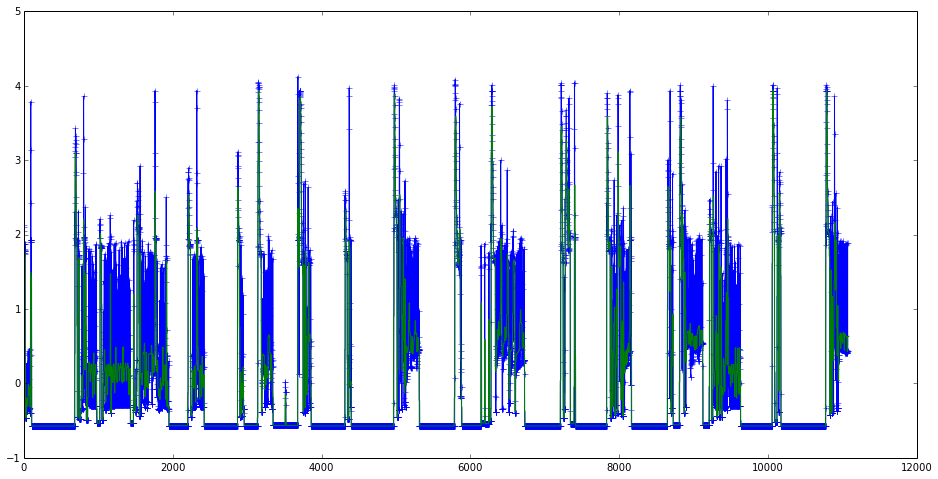

In [20]:
paaTransform = paa_transform(zScores,1386)
paaTransfo = np.repeat(paaTransform,8, axis = 0)
pl.figure()
pl.plot(zScores, '-+')
pl.plot(paaTransfo)
pl.legend(loc = "upper left")

In [21]:
originalGraphDf=pd.DataFrame(originalGraph)
paaTransfoDf=pd.DataFrame(paaTransfo)
paaTransfoDf=paaTransfoDf.iloc[:paaTransfoDf.size-15]
paaTransfoDf.index=originalGraphDf.index
graph = pd.concat([paaTransfoDf,zScores],axis=1).dropna()
charts.plot(graph,stock=True,show='inline')


In [22]:
saxTransformation=sax_transform(originalGraph, 1386, "abcdefghijklmn")

In [23]:
'''
Werkwijze:
Dataframes gebruiken!
-sax transfo
-letters->nummers (makeArray())
-np.repeat (plateau's)
-plot(paa_transform+repeater,^)
'''

letters=pd.DataFrame(saxTransformation)
letters.columns=['col1']
lettersToNumSax=makeArray(letters.col1) #Expects a pandaframe

repeatedValues=np.repeat(lettersToNumSax.as_matrix(),8) #expects an array

dfRepeatedValues=pd.DataFrame(repeatedValues)

dfRepeatedValues=dfRepeatedValues.iloc[:dfRepeatedValues.size-7]
paaTransfoDf.index=dfRepeatedValues.index

concatinatePaaAndSax=pd.concat([znormalization(dfRepeatedValues),paaTransfoDf],axis=1)
concatinatePaaAndSax.columns=['col1','col2']

charts.plot(concatinatePaaAndSax,stock=True,show='inline')


In [27]:
dfRepeatedValues.index=zScores.index
saxVsOriginalGraph=pd.concat([(dfRepeatedValues), znormalization(originalGraph)],axis=1).dropna()
charts.plot(saxVsOriginalGraph, stock=True, show='inline')


In [28]:
dfRepeatedValues.ix[pd.Timestamp('2015-11-13 16:25:00+00:00'):pd.Timestamp('2015-11-13 17:16:00+00:00')]

,0
2015-11-13 16:25:00+00:00,3
2015-11-13 16:26:00+00:00,3
2015-11-13 16:27:00+00:00,11
2015-11-13 16:28:00+00:00,11
2015-11-13 16:29:00+00:00,11
2015-11-13 16:30:00+00:00,11
2015-11-13 16:31:00+00:00,11
2015-11-13 16:32:00+00:00,11
2015-11-13 16:33:00+00:00,11
2015-11-13 16:34:00+00:00,11
